**Connected to Elasticsearch**

In [2]:
from pprint import pprint
from elasticsearch import Elasticsearch

es = Elasticsearch("http://localhost:9200")

client_info = es.info()

print("Connected to Elasticsearch!")

pprint(client_info.body)

Connected to Elasticsearch!
{'cluster_name': 'docker-cluster',
 'cluster_uuid': 'T1HeaWnRTOqX_BBgREVVbA',
 'name': '64c49e436740',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2025-10-21T10:06:21.288851013Z',
             'build_flavor': 'default',
             'build_hash': '25d88452371273dd27356c98598287b669a03eae',
             'build_snapshot': False,
             'build_type': 'docker',
             'lucene_version': '10.3.1',
             'minimum_index_compatibility_version': '8.0.0',
             'minimum_wire_compatibility_version': '8.19.0',
             'number': '9.2.0'}}


**Create Index**

**🧩 What is an ILM Policy?**

ILM stands for Index Lifecycle Management — it’s a feature in Elasticsearch that automatically manages the life cycle of your indexes (or data streams) to balance:

1. ✅ Performance
2. 💾 Storage efficiency
3. 💰 Cost control

**Create ILM Policy for HOT and DELETE storage**

In [6]:
from pprint import pprint 

# Define the ILM policy
ilm_policy = {
    "phases": {
        "hot": {
            "actions": {
                "rollover": {
                    "max_age": "5m",
                    "max_size": "500mb"
                }
            }
        },
        # "warm": {
        #     "min_age": "7d",
        #     "actions": {
        #         "allocate": {"require": {"data": "warm"}},
        #         "forcemerge": {"max_num_segments": 1}
        #     }
        # },
        # "cold": {
        #     "min_age": "30d",
        #     "actions": {
        #         "allocate": {"require": {"data": "cold"}}
        #     }
        # },
        "delete": {
            "min_age": "20m",
            "actions": {
                "delete": {}
            }
        }
    }
}

# Create the ILM policy in Elasticsearch
response = es.ilm.put_lifecycle(name="cpu_usage_policy_v2", policy=ilm_policy)

print("ILM policy created successfully:")
pprint(response.body)


ILM policy created successfully:
{'acknowledged': True}


**Index Template**

In [ ]:
# Define the index template body
body = {
    "index_patterns": ["cpu_example_template*"],  # Matches indices or data streams starting with this prefix
    "data_stream": {},  # Enables data stream support
    "priority": 500,  # Higher priority than system templates
    "template": {
        "settings": {
            "index.mode": "time_series",  # Enable TSDS (Time Series Data Stream) mode
            "index.lifecycle.name": "cpu_usage_policy_v2"  # Attach ILM policy for lifecycle management
        },
        "mappings": {
            "properties": {
                "@timestamp": {
                    "type": "date"  # Timestamp for time-series data
                },
                "cpu_usage": {
                    "type": "float",
                    "time_series_metric": "gauge"  # Type of metric value
                },
                "cpu_name": {
                    "type": "keyword",
                    "time_series_dimension": True  # Dimension to group metrics (like per CPU core)
                }
            }
        }
    },
    "_meta": {
        "description": "Template for CPU usage time-series data"
    },
    "allow_auto_create": True
}

# Create the template
response = es.indices.put_index_template(name="cpu_example_template", body=body)

print("Index template created successfully:")
print(response)

{'acknowledged': True}


**Index Data**

In [8]:
import psutil
from datetime import datetime


index_alias = "cpu_example_template"
while True:
    document = {
        "@timestamp": datetime.utcnow(),
        "cpu_usage": psutil.cpu_percent(interval=0.1),
        "cpu_name": "i7-13650HX"
    }

    es.index(index=index_alias, document=document, refresh=True)

C:\Users\bmmah\AppData\Local\Temp\ipykernel_13068\1949228889.py:8: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "@timestamp": datetime.utcnow(),


KeyboardInterrupt: 

In [9]:
count = es.count(index="cpu_example_template")
pprint(count.body)

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'count': 81}


In [10]:
response = es.search(
    index="cpu_example_template",
    body={
        "query": {
            "match_all": {}
        },
        "size": 1000
    },
)
hits = response.body["hits"]["hits"]

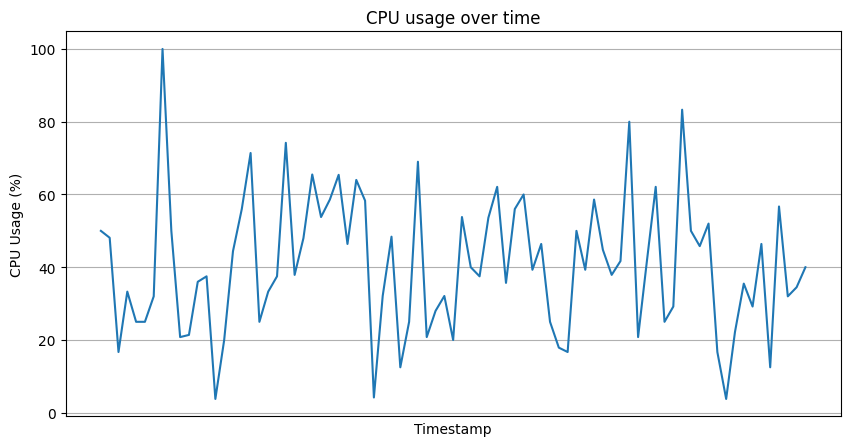

In [11]:
import matplotlib.pyplot as plt

cpu_usage_values = [hit["_source"]["cpu_usage"] for hit in hits]
timestamp_values = [hit["_source"]["@timestamp"] for hit in hits]

plt.figure(figsize=(10, 5))
plt.plot(timestamp_values, cpu_usage_values)
plt.xticks([])
plt.xlabel("Timestamp")
plt.ylabel("CPU Usage (%)")
plt.title("CPU usage over time")
plt.grid(True)
plt.show()